# TOC

* [import libraries and source files](#import-libraries-and-source-files)
* [functions definitions](#functions-for-calculations)
* [looking at average shapes visually](#looking-at-average-shapes-visually)

you could just jump to "looking at average shapes visually" to check the comparsion between a few methods

# import libraries and source files
and get Dataframes needed for calculations

In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 96

In [3]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--gapminder_gini--by--geo--time.csv'
shapes_file = '../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv'

In [4]:
income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['geo', 'time'])
gini.index.names = ['country', 'time']
shapes = pd.read_csv(shapes_file)

In [5]:
# convert xkx to kos. Same country, but povcal and open-numbers use different code
shapes['country'] = shapes['country'].replace({'xkx': 'kos'})

In [6]:
# create a sorted version
shapes_ = shapes.set_index(['country', 'year']).sort_index()

In [7]:
merge = pd.concat([income, gini], axis=1)

In [8]:
# get all available country/year pair from povcal

unique_country_year = shapes[['country', 'year']].drop_duplicates()

known_income = list()
known_gini = list()

for _, row in unique_country_year.iterrows():
    r = (row['country'], row['year'])
    if r in merge.index:
        i = merge.loc[r, 'mincpcap_cppp']
        g = merge.loc[r, 'gapminder_gini']
    else:
        i = np.nan
        g = np.nan
    known_income.append(i)
    known_gini.append(g)
    
idx = pd.MultiIndex.from_frame(unique_country_year)
known_country_year_df = pd.DataFrame({'income': known_income, 'gini': known_gini}, index=idx)

In [9]:
known_country_year_df

income  gini
country year              
ago     1981  5.5461  53.8
        1982  5.3525  53.7
        1983  5.3818  53.6
        1984  5.5050  53.5
        1985  5.4991  53.4
...              ...   ...
zwe     2015  4.4835  43.2
        2016  4.1485  43.2
        2017  3.9717  43.2
        2018  4.2896  43.2
        2019  4.0536  43.2

[6409 rows x 2 columns]

# functions for calculation

In [10]:
100 * 364

36400

In [11]:
# calculate distances from one point to all known income/gini points as in 2D plane.
# the distance is calculated by sqrt(gini_distance^2 + income_distance^2)
# and gini_distance and income_distance are standarized so that 1 means +/- 10% 

def get_distances(income, gini):
    """distance in 2D plane"""
    gini_distances = (known_country_year_df['gini'] - gini) / gini * 10
    # income: maybe better to use log scale?
    income_distances = (np.log(known_country_year_df['income']) - np.log(income)) * 10
    # income_distances = (known_country_year_df['income'] - income) / income * 10
    
    
    res = np.sqrt(np.power(income_distances, 2) + 
                  np.power(gini_distances, 2))
    return res.sort_values(ascending=True).dropna()

In [12]:
# for example
get_distances(5.3, 53)

country  year
ago      1982     0.164802
nic      1989     0.179365
ago      1983     0.190458
         1989     0.257413
cpv      1997     0.282925
                   ...    
are      1982    36.599022
         2004    36.651634
         2001    36.855541
         2002    36.937969
         1981    37.895079
Length: 6350, dtype: float64

In [13]:
# TODO: add get_neighbors by rectangle 

In [14]:
# get n neighbor countries
# radius: max distance allowed
# only_once: only include one country for once
# n: max countries allowed
def get_neighbors_n_countries(income, gini, n=5, radius=1.414, only_once=False):
    neis = list()
    ecs = set()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]  # droping res= 0, because exact match means it's same point
    for i, v in res.iteritems():
        if only_once and i[0] in ecs:
            continue
        ecs.add(i[0])
        neis.append(i)
        if len(ecs) >= n:
            break
    if len(ecs) < n:
        print(f'can not get enough countries, only {len(ecs)} countries selected')
    return neis

In [15]:
get_neighbors_n_countries(5.3, 53, 5)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986),
 ('ago', 1987),
 ('ago', 1985),
 ('ago', 1984),
 ('ken', 1992),
 ('ago', 1990),
 ('ago', 1981),
 ('swz', 2013)]

In [16]:
get_neighbors_n_countries(5.3, 53, 5, only_once=True)

[('ago', 1982), ('nic', 1989), ('cpv', 1997), ('ken', 1992), ('swz', 2013)]

In [17]:
# get n neighbor points
# radius: max distance allowed
# n: max points allowed
def get_neighbors_n_points(income, gini, n=10, radius=1.414):
    neis = list()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]
    for i, v in res.iteritems():
        neis.append(i)
        if len(neis) >= n:
            break
    if len(neis) < n:
        print(f'can not get enough points, only {len(neis)} points selected')
    return neis

In [18]:
get_neighbors_n_points(5.3, 53, 5)

[('ago', 1982), ('nic', 1989), ('ago', 1983), ('ago', 1989), ('cpv', 1997)]

In [19]:
get_neighbors_n_points(5.3, 53, 6)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986)]

In [20]:
def get_income_gini(idx):
    i = merge.loc[idx, 'mincpcap_cppp']
    g = merge.loc[idx, 'gapminder_gini']
    return i, g

In [21]:
# function for merging shapes
# s_list: a list of shapes objects (pd.Series)
def merge_nshapes(s_list):
    n = len(s_list)
    res = pd.concat(s_list, axis=1).fillna(0)
    return res.mean(axis=1)

In [22]:
# get shape from known shapes
def get_shape(idx):
    df = shapes_.loc[idx]
    for t in 'naur':
        if t in df['coverage_type'].values:
            if t in 'ur':
                print(f'{idx}: using urban/rural data')
            df_nc = df[df['coverage_type'] == t]
            df_nc = df_nc.set_index('bracket')['population_percentage']
            return df_nc

In [23]:
def get_estimated_shape(idx, method, use_known_shape=False, **kwargs):
    # 1. if the idx is in known shapes and use_known_shape=True, just return the known shape
    # 2. if not, return the estimated shape by given method. kwargs will be used as the given
    # method's parameters.
    if idx in shapes_.index:
        if use_known_shape:
            return get_shape(idx)
        else:
            i, g = get_income_gini(idx)
            nei = method(i, g, **kwargs)
            nei = [x for x in nei if x != idx]  # remove itself from neighbours
            print(f'using {len(nei)} shapes')
            # print(nei)
            slist = list(map(get_shape, nei))
            return merge_nshapes(slist)
    else:
        i, g = get_income_gini(idx)
        nei = method(i, g, **kwargs)
        print(f'using {len(nei)} shapes')
        slist = list(map(get_shape, nei))
        return merge_nshapes(slist)

In [24]:
# example usage:
x = ('usa', 1990)
i, g = get_income_gini(x)
res1 = get_shape(x)
res2 = get_estimated_shape(x, get_neighbors_n_countries, n=10)

can not get enough countries, only 4 countries selected
using 30 shapes


In [25]:
# function for telling difference between estimated and actual shapes
def mean_square_for_2shapes(s1, s2):
    s1_, s2_ = s1.align(s2)
    rms = np.sqrt(np.sum(np.power(s1_ - s2_, 2)))
    return rms

In [26]:
mean_square_for_2shapes(res1, res2)

0.012895856884200349

# looking at average shapes visually

Below are some examples for comparsion between estimated shapes and actual shapes using different neighbor selecting approaches. 

Please Note:
1. the distance is calculated as in 2D plane: sqrt(gini_distance^2 + income_distance^2), 
    - and gini_distance and income_distance are standarized so that 1 means +/-10%. 
    - Below examples we are selecting neighbors in circles using radius=sqrt(2), 
    - which means for a given (gini, income) pair, the neighbors' gini will be in the range (gini - 10%, gini + 10%) and so as to income.
    

In [27]:
def do_plot(x, ns, method, **kwargs):
    i, g = get_income_gini(x)
    print(x)
    print(f"i = {i}, g = {g}")
    res1 = get_shape(x)
    
    for i, n in enumerate(ns):
        print(f'n = {n}')
        plt.subplot(2, 2, i+1)
        res2 = get_estimated_shape(x, method, n=n, **kwargs)
        rms = mean_square_for_2shapes(res1, res2)
        plt.plot(res1, label='actual')
        plt.plot(res2, label='estimated')
        plt.title(f"n={n}, rms={rms:.6f}")
        plt.legend()

## example 1: swe 2015

### 1. N countries, no repeating

('swe', 2015)
i = 55.2617, g = 28.8
n = 5
using 5 shapes
n = 10
using 10 shapes
n = 15
can not get enough countries, only 14 countries selected
using 14 shapes
n = 20
can not get enough countries, only 14 countries selected
using 14 shapes


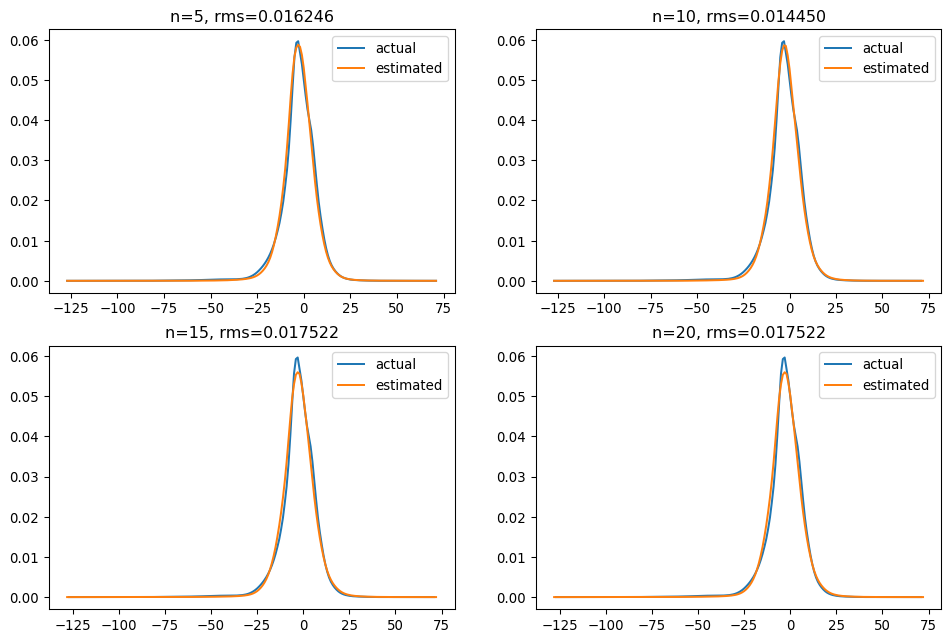

In [28]:
ns = [5, 10, 15, 20]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)  # one country only exist once in neighbor list

## 2. N countries, allow multiple occurrences

('swe', 2015)
i = 55.2617, g = 28.8
n = 5
using 7 shapes
n = 10
using 56 shapes
n = 15
can not get enough countries, only 14 countries selected
using 151 shapes
n = 20
can not get enough countries, only 14 countries selected
using 151 shapes


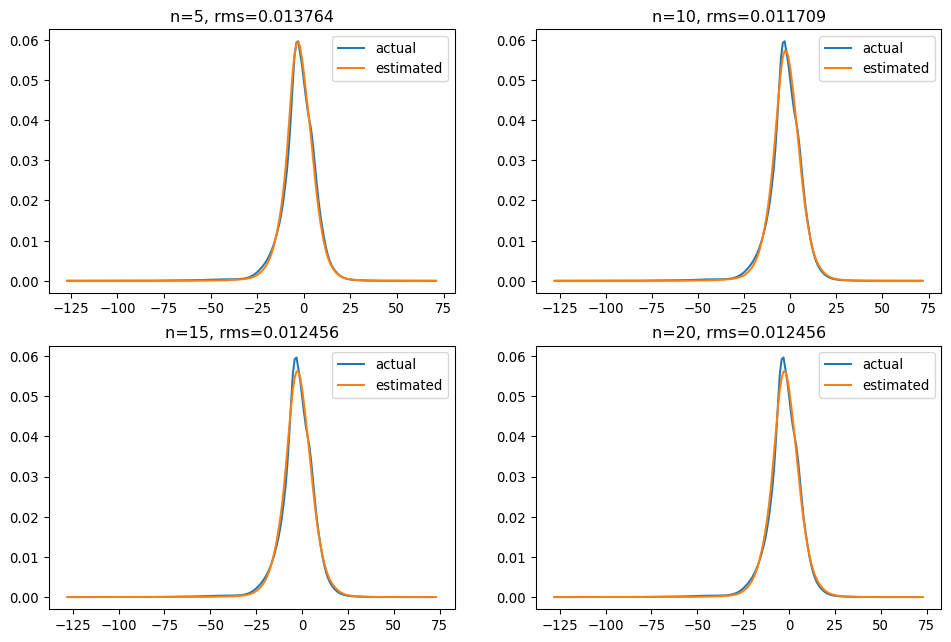

In [29]:
ns = [5, 10, 15, 20]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points

('swe', 2015)
i = 55.2617, g = 28.8
n = 10
using 10 shapes
n = 20
using 20 shapes
n = 40
using 40 shapes
n = 80
using 80 shapes


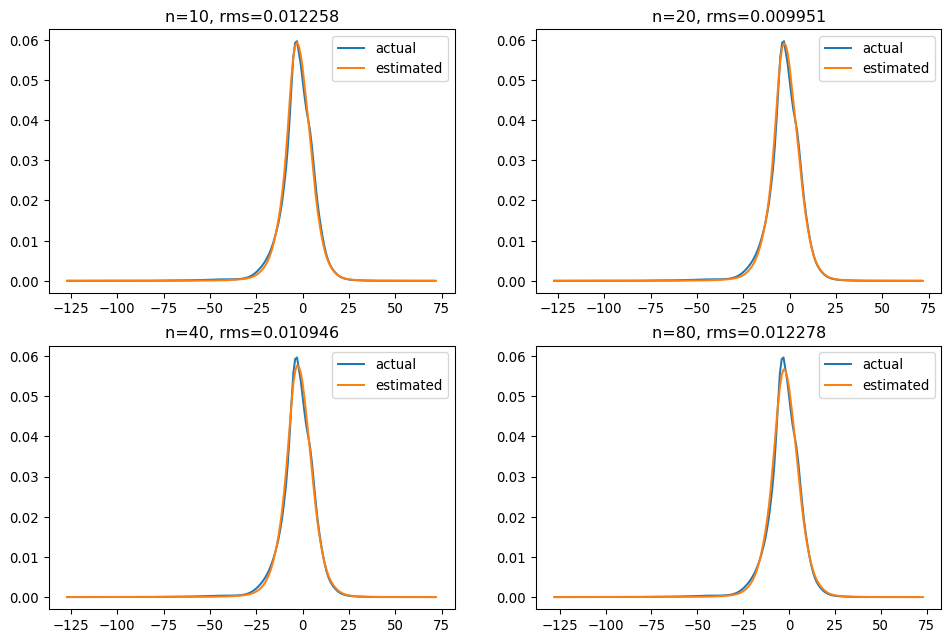

In [30]:
ns = [10, 20, 40, 80]
x = ('swe', 2015)

do_plot(x, ns, get_neighbors_n_points)

## example 2: Brazil 1990

### 1. N countries, no repeating

('bra', 1990)
i = 9.4026, g = 59.0
n = 5
using 5 shapes
('sur', 2001): using urban/rural data
n = 10
using 10 shapes
('sur', 2001): using urban/rural data
n = 15
using 15 shapes
('sur', 2001): using urban/rural data
n = 20
can not get enough countries, only 18 countries selected
using 18 shapes
('sur', 2001): using urban/rural data
('arg', 2002): using urban/rural data


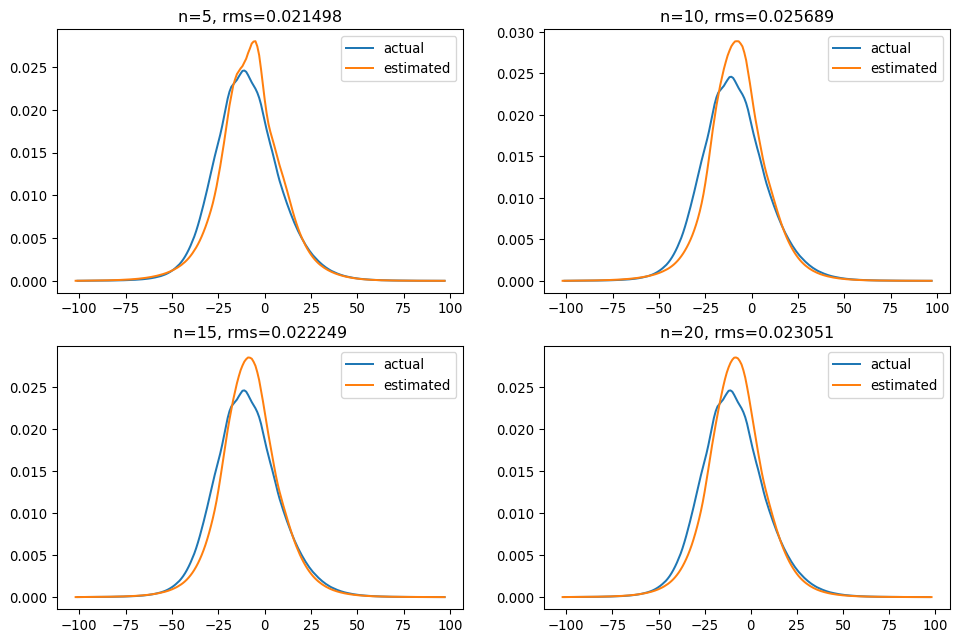

In [31]:
ns = [5, 10, 15, 20]
x = ('bra', 1990)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)

## 2. N countries, allow multiple occurrences

('bra', 1990)
i = 9.4026, g = 59.0
n = 5
using 7 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
n = 10
using 20 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
n = 15
using 95 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
('sur', 1994): using urban/rural data
('sur', 1995): using urban/rural data
('sur', 1996): using urban/rural data
('sur', 1992): using urban/rural data
('sur', 2003): using urban/rural data
('sur', 1993): using urban/rural data
('sur', 1991): using urban/rural data
('sur', 1990): using urban/rural data
('sur', 1987): using urb

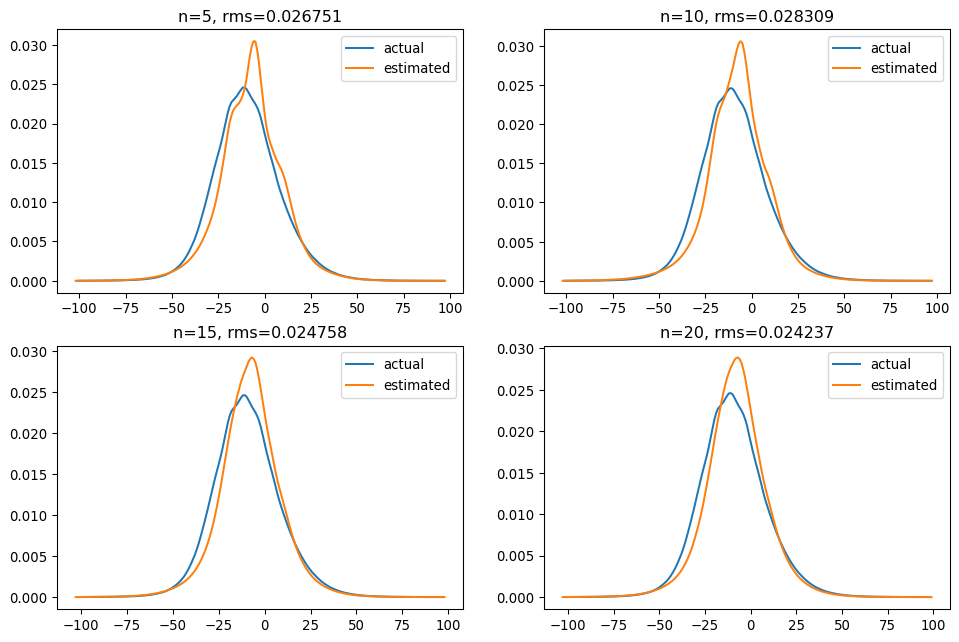

In [32]:
ns = [5, 10, 15, 20]
x = ('bra', 1990)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points

('bra', 1990)
i = 9.4026, g = 59.0
n = 10
using 10 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
n = 20
using 20 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
n = 40
using 40 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data
('sur', 1997): using urban/rural data
('sur', 1999): using urban/rural data
('sur', 1994): using urban/rural data
('sur', 1995): using urban/rural data
('sur', 1996): using urban/rural data
n = 80
using 80 shapes
('sur', 2001): using urban/rural data
('sur', 2002): using urban/rural data
('sur', 2000): using urban/rural data
('sur', 1998): using urban/rural data

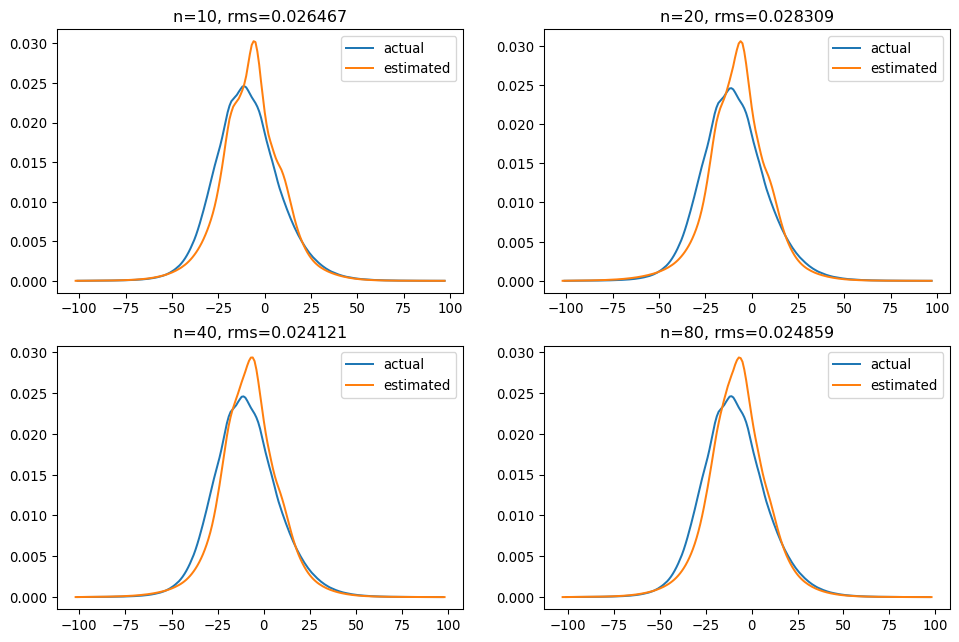

In [33]:
ns = [10, 20, 40, 80]
x = ('bra', 1990)


do_plot(x, ns, get_neighbors_n_points)

# example 3: Malawi 1991

This shape seems to be special. Because high gini countries' shapes are usually wide

### 1. N countries, no repeating

('mwi', 1991)
i = 3.452, g = 61.0
n = 5
using 5 shapes
n = 10
using 10 shapes
n = 15
can not get enough countries, only 10 countries selected
using 10 shapes
n = 20
can not get enough countries, only 10 countries selected
using 10 shapes


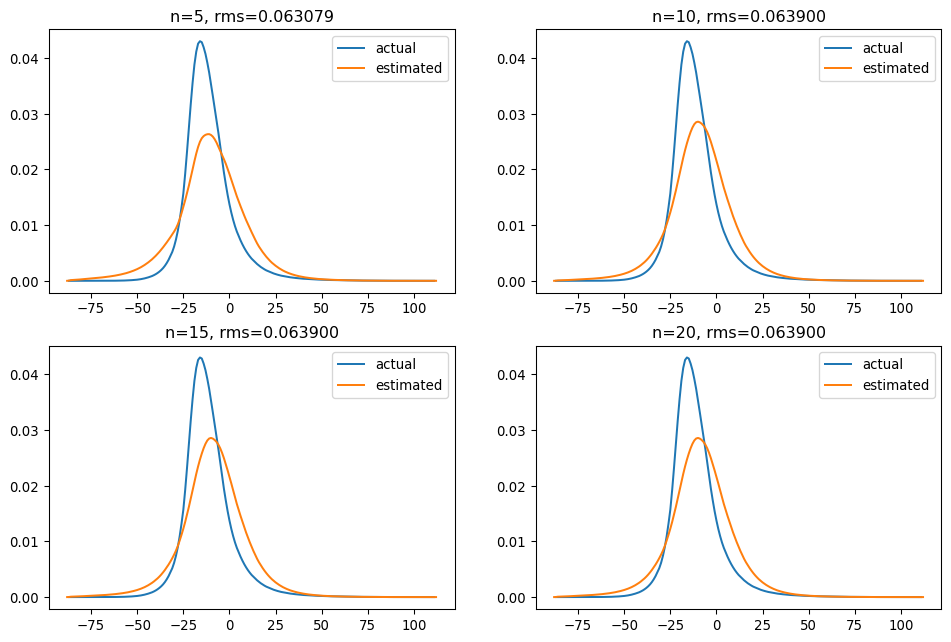

In [34]:
ns = [5, 10, 15, 20]
x = ('mwi', 1991)

do_plot(x, ns, get_neighbors_n_countries, only_once=True)

## 2. N countries, allow multiple occurrences

('mwi', 1991)
i = 3.452, g = 61.0
n = 5
using 26 shapes
n = 10
using 58 shapes
n = 15
can not get enough countries, only 10 countries selected
using 58 shapes
n = 20
can not get enough countries, only 10 countries selected
using 58 shapes


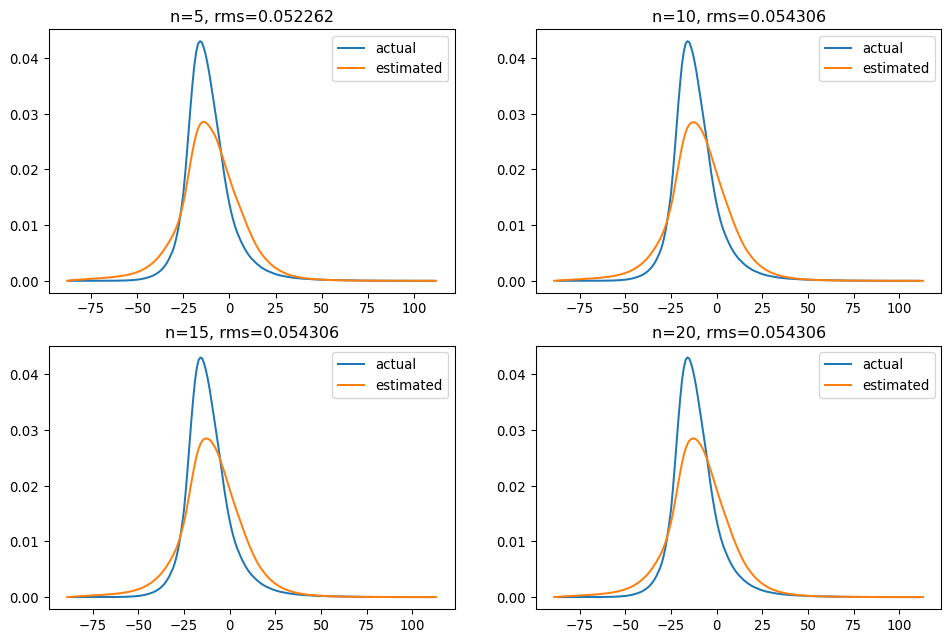

In [35]:
ns = [5, 10, 15, 20]
x = ('mwi', 1991)

do_plot(x, ns, get_neighbors_n_countries, only_once=False)

## 3. nearest N points


('mwi', 1991)
i = 3.452, g = 61.0
n = 10
using 10 shapes
n = 20
using 20 shapes
n = 40
using 40 shapes
n = 80
can not get enough points, only 58 points selected
using 58 shapes


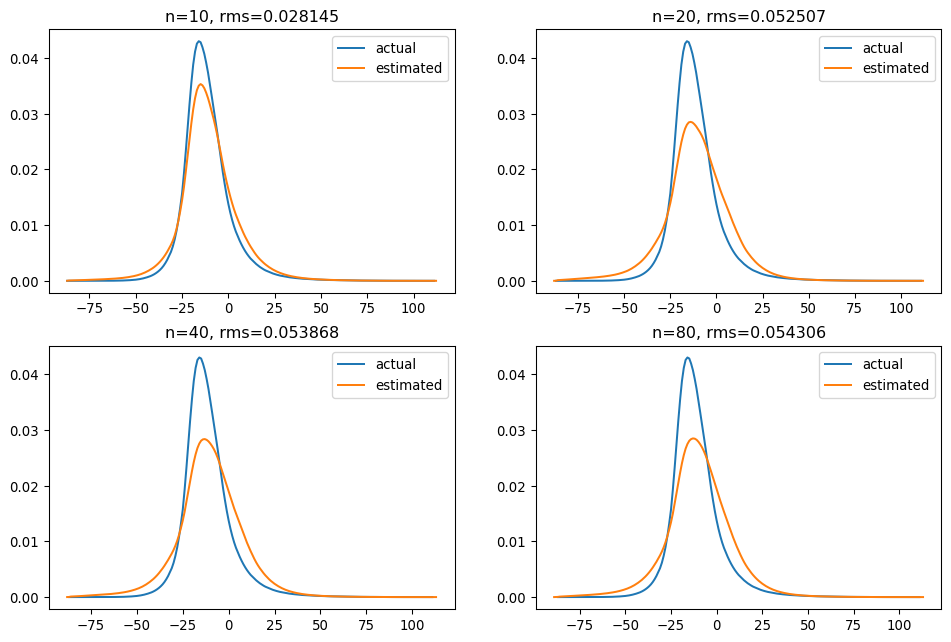

In [36]:
ns = [10, 20, 40, 80]
x = ('mwi', 1991)


do_plot(x, ns, get_neighbors_n_points)

In [37]:
i, g = get_income_gini(x)
get_distances(i, g)

country  year
mwi      1991     0.000000
         1999     0.187974
         1993     0.315371
lso      1998     0.397664
zmb      1988     0.486785
                   ...    
are      1982    40.949235
         2004    41.001779
         2001    41.205424
         2002    41.287746
         1981    42.243655
Length: 6350, dtype: float64